In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tqdm import tqdm
import missingno as msno
import seaborn as sns
import statsmodels.api as sm
import pickle
from statsmodels.nonparametric.smoothers_lowess import lowess
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
import warnings
warnings.simplefilter('ignore') # 
from scipy.interpolate import UnivariateSpline

## RPS Scores Analysis

In [2]:
merged_scores = pd.read_csv('all_rps.csv')

In [3]:
# Create a mapping dictionary for state names to their two-letter abbreviations
state_abbreviation_mapping = {
    'california': 'CA', 'oregon': 'OR', 'new-york': 'NY', 'vermont': 'VT', 'washington-dc': 'DC',
    'maryland': 'MD', 'maine': 'ME', 'delaware': 'DE', 'colorado': 'CO', 'connecticut': 'CT',
    'new-jersey': 'NJ', 'massachusetts': 'MA', 'hawaii': 'HI', 'washington': 'WA', 'rhode-island': 'RI',
    'pennsylvania': 'PA', 'michigan': 'MI', 'iowa': 'IA', 'nebraska': 'NE', 'nevada': 'NV',
    'new-hampshire': 'NH', 'alaska': 'AK', 'montana': 'MT', 'north-carolina': 'NC', 'virginia': 'VA',
    'new-mexico': 'NM', 'florida': 'FL', 'illinois': 'IL', 'north-dakota': 'ND', 'arizona': 'AZ',
    'utah': 'UT', 'wisconsin': 'WI', 'georgia': 'GA', 'kansas': 'KS', 'texas': 'TX',
    'idaho': 'ID', 'indiana': 'IN', 'ohio': 'OH', 'south-carolina': 'SC', 'missouri': 'MO',
    'kentucky': 'KY', 'south-dakota': 'SD', 'louisiana': 'LA', 'tennessee': 'TN', 'west-virginia': 'WV',
    'arkansas': 'AR', 'wyoming': 'WY', 'mississippi': 'MS', 'alabama': 'AL', 'oklahoma': 'OK','minnesota':'MN'}

# Apply the mapping to the State column
merged_scores['State'] = merged_scores['State'].map(state_abbreviation_mapping)

In [4]:
# Define the number of quantiles
num_quantiles = 4

# Create a dictionary to store the edges for each score
edges = {}

# Apply pd.qcut for each score and store the edges
for score_column in ['4o-mini RPS Score', 'Milcheva RPS', 'o1-mini RPS Score', 'Gemeni RPS Score', 'Claude RPS Score']:
    _, bins = pd.qcut(merged_scores[score_column], q=num_quantiles, retbins=True, duplicates='drop')
    edges[score_column] = bins

# Display the edges for each score
for score_column, bins in edges.items():
    print(f"Edges for {score_column}: {bins}")

Edges for 4o-mini RPS Score: [ 9. 15. 18. 21. 30.]
Edges for Milcheva RPS: [ 4.  10.5 14.  17.  22. ]
Edges for o1-mini RPS Score: [ 7. 16. 18. 22. 28.]
Edges for Gemeni RPS Score: [12. 16. 18. 19. 28.]
Edges for Claude RPS Score: [10. 16. 18. 24. 30.]


In [5]:
merged_scores['4o-mini RPS Group']= pd.qcut(merged_scores['4o-mini RPS Score'], q=4, labels=['Below 15', 'Between 15-18', 'Between 18-21', 'Above 21'])
merged_scores['Milcheva RPS Group']= pd.cut(merged_scores['Milcheva RPS'], bins=[0,10, 14, 17, 23], labels=['Below < 10', 'Between 10-13', 'Between 14-16', 'Between 17-22'])
merged_scores['o1-mini RPS Group']= pd.qcut(merged_scores['o1-mini RPS Score'], q=4, labels=['Below 16', 'Between 16-18', 'Between 18-22', 'Above 22'])
merged_scores['Gemeni RPS Group']= pd.qcut(merged_scores['Gemeni RPS Score'], q=4, labels=['Below 16', 'Between 16-18', 'Between 18-19', 'Above 19'])
merged_scores['Claude RPS Group']= pd.qcut(merged_scores['Claude RPS Score'], q=4, labels=['Below 16', 'Between 16-18', 'Between 18-24', 'Above 24'])

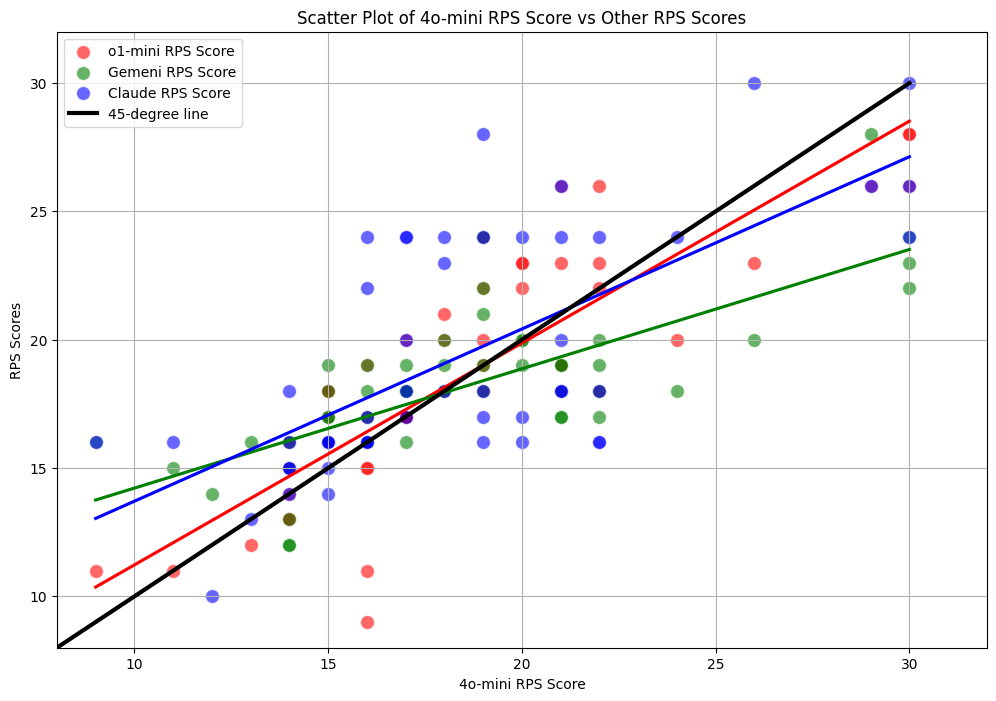

In [6]:
# List of RPS scores to plot against 4o-mini RPS Score
rps_scores = ['o1-mini RPS Score', 'Gemeni RPS Score', 'Claude RPS Score']

# Create a figure and axis
plt.figure(figsize=(12, 8))

# Define colors for each score
colors = ['red', 'green', 'blue']

# Plot each score
for score, color in zip(rps_scores, colors):
    # Scatter plot
    sns.scatterplot(x='4o-mini RPS Score', y=score, data=merged_scores, s=100, alpha=0.6, label=score, color=color)
    
    # Fit a line without confidence interval
    sns.regplot(x='4o-mini RPS Score', y=score, data=merged_scores, scatter=False, color=color, ci=None)

# Add 45-degree line
max_val = max(merged_scores['4o-mini RPS Score'].max(), merged_scores[rps_scores].max().max())
plt.plot([0, max_val], [0, max_val], color='black', linewidth=3, linestyle='-', label='45-degree line')
plt.xlim(8, 32)
plt.ylim(8, 32)

# Set plot details
plt.title('Scatter Plot of 4o-mini RPS Score vs Other RPS Scores')
plt.xlabel('4o-mini RPS Score')
plt.ylabel('RPS Scores')
plt.grid(True)
plt.legend()
plt.show()

In [7]:
ret = pd.read_pickle('fannie_non_fannie_ret.pkl')

In [8]:
ret = ret.merge(merged_scores[['State','4o-mini RPS Group', 'Milcheva RPS Group', 'o1-mini RPS Group', 'Gemeni RPS Group', 'Claude RPS Group']], left_on='Property State', right_on='State', how='left')

In [9]:
# Function to plot binned scatter plots for each return column with all groups in one plot
def plot_binned_scatter_combined_by_return(data, return_columns, group_column, num_bins=10, title_prefix='Return by Group', figsave_name=None):
    for idx, ret_col in enumerate(return_columns):
        # Initialize a figure
        fig, ax = plt.subplots(figsize=(12, 8))

        # Get unique groups
        if group_column == '4o-mini RPS Group':
            groups = ['Below 15', 'Between 15-18', 'Between 18-21', 'Above 21']
        elif group_column == 'Milcheva RPS Group':
            groups = ['Below < 10', 'Between 10-13', 'Between 14-16', 'Between 17-22']
        elif group_column == 'o1-mini RPS Group':
            groups = ['Below 16', 'Between 16-18', 'Between 18-22', 'Above 22']
        elif group_column == 'Gemeni RPS Group':
            groups = ['Below 16', 'Between 16-18', 'Between 18-19', 'Above 19']
        elif group_column == 'Claude RPS Group':
            groups = ['Below 16', 'Between 16-18', 'Between 18-24', 'Above 24']
        elif group_column == 'EPU Group':
            groups = ['Below 69', 'Between 68-82', 'Between 82-100', 'Above 100']
            
        #groups = data[group_column].unique()

        # Define colors for the groups
        colors = ['blue', 'green', 'red', 'orange']   # Generate distinct colors for groups
        return_mapping = {
            'Underwritten Cap Rate': 'Net Rental Yield',
            'Hedonic Ret A=0.5': 'Capital Gain A=0.5',
            'Total Ret A=0.5': 'Total Return A=0.5'
        }
        # Loop through each group and plot on the same graph
        for i, group in enumerate(groups):
            group_data = data[data[group_column] == group]

            # Apply binning based on Real Underwritten Annual NCF Per Unit
            group_data['NOI_Bin'], bin_edges = pd.qcut(
                group_data['Real Underwritten Annual NCF Per Unit'], 
                q=num_bins, 
                retbins=True, 
                duplicates='drop'
            )

            # Filter the return column data
            filtered_data = group_data[(group_data[ret_col] >= -0.05) & (group_data[ret_col] <= 0.24)]

            # Calculate the mean NOI and dependent variable for each bin
            binned_data = filtered_data.groupby('NOI_Bin').agg({
                'Real Underwritten Annual NCF Per Unit': 'median',
                ret_col: 'median'
            }).reset_index().rename(columns={'Real Underwritten Annual NCF Per Unit': 'mean_noi'})

            # New 250130: Convert annual NOI to monthly NOI
            binned_data['mean_noi'] = binned_data['mean_noi']/12

            # Plot data points for the current group
            sns.scatterplot(
                data=binned_data,
                x='mean_noi',
                y=ret_col,
                ax=ax,
                color=colors[i],
                alpha=0.7,
                label=f'{group}'
            )

            # Fit a spline through the binned data points
            if not binned_data.empty:
                spline = UnivariateSpline(binned_data['mean_noi'], binned_data[ret_col], s=1)
                x_spline = np.linspace(min(binned_data['mean_noi']), max(binned_data['mean_noi']), 500)
                y_spline = spline(x_spline)
                ax.plot(x_spline, y_spline, color=colors[i])
        
        # Set plot details
        # New formats 250130
        ax.set_xlabel('Net Rent', fontsize=22)
        ax.set_ylabel('Return', fontsize=22)
        ax.tick_params(axis='both', labelsize=20)  # Increase font size for both x and y ticks
        if ret_col == 'Underwritten Cap Rate':   # rename
            ret_col = 'Net Rental Yield'

        # ax.set_xlim(0, 30000)
        # ax.set_xlabel('Real Underwritten Annual NCF Per Unit', fontsize=14)
        # ax.set_ylabel('Return', fontsize=14)
        

        plt.title(f'{title_prefix}: {ret_col}', fontsize=22)   # used to be 16
        plt.grid(True)
        plt.legend(title=group_column, fontsize=20, title_fontsize=20)
        plt.tight_layout()

        if figsave_name:   # New 
            plt.savefig(f'Figures/{figsave_name[idx]}.png')

        plt.show()

# Updated list with all the return columns in your DataFrame
return_columns = ['Underwritten Cap Rate','Hedonic Ret A=0.5', 'Total Ret A=0.5']

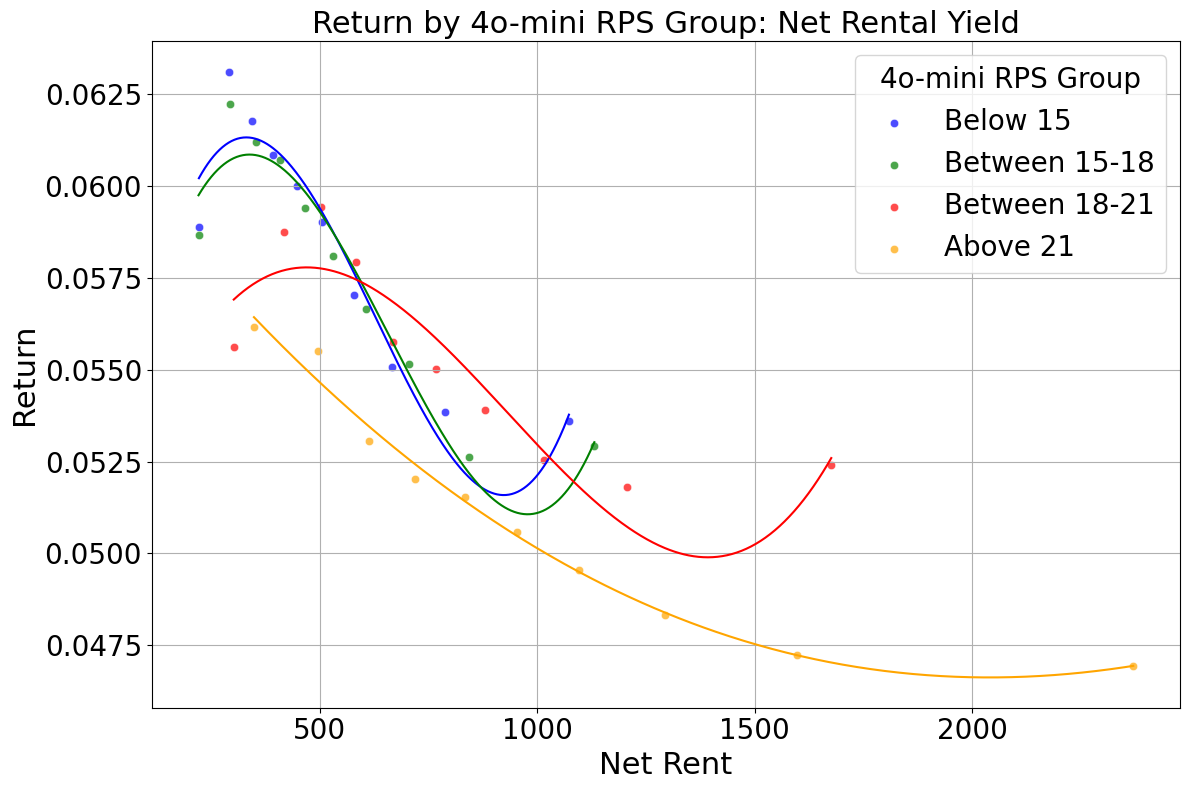

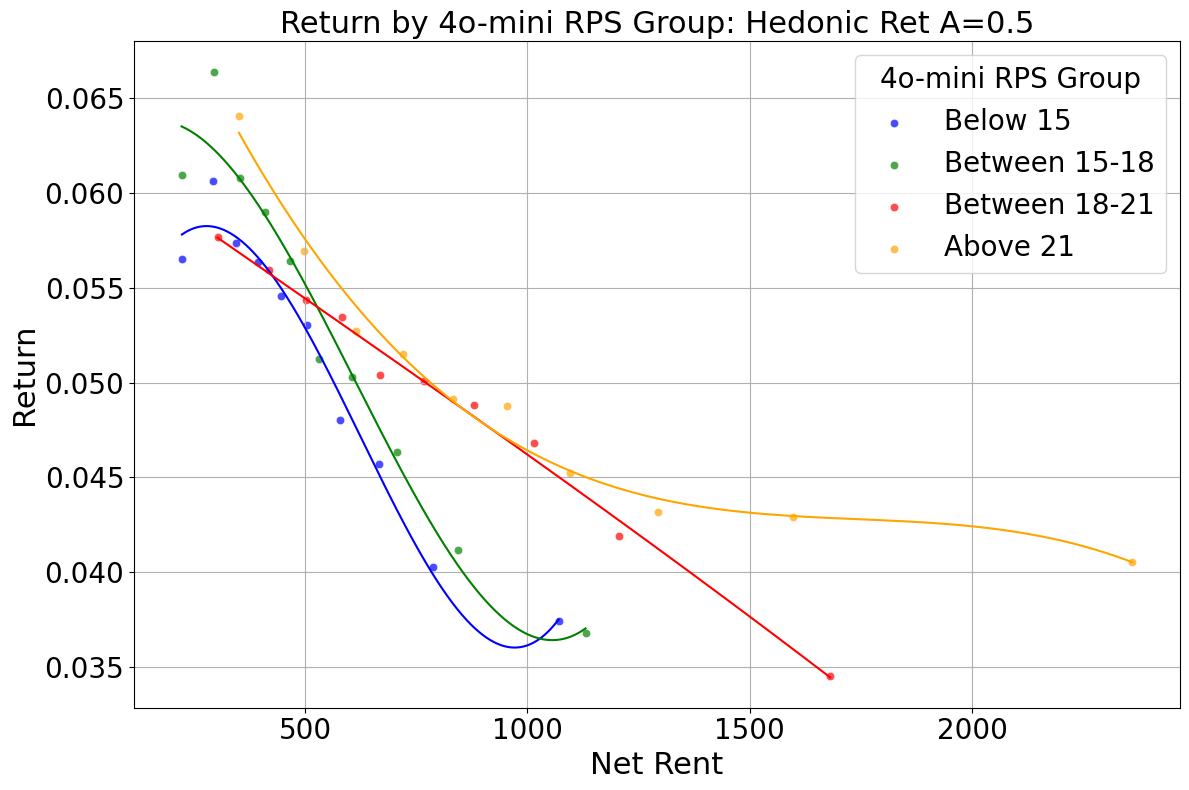

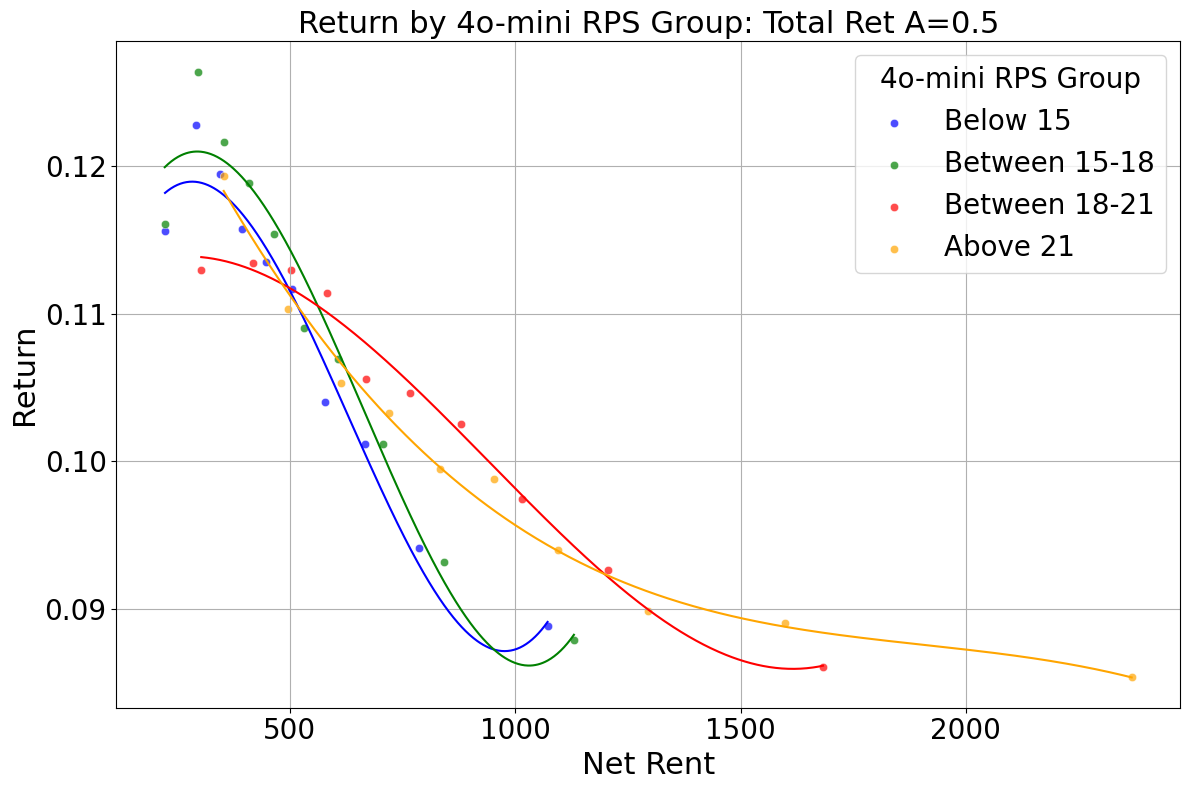

In [10]:
# Plot each return column with all groups in one plot
figsave_name = ['rps_cap_rate', 'rps_cap_gain', 'rps_tot_ret']
plot_binned_scatter_combined_by_return(ret, return_columns, '4o-mini RPS Group', title_prefix='Return by 4o-mini RPS Group', figsave_name=figsave_name)

# NOTE: INFORCE Figure 17: Cap Rates and Returns by Tenant Protection Groups  rps_cap_rate.png rps_cap_gain.png rps_tot_ret.png

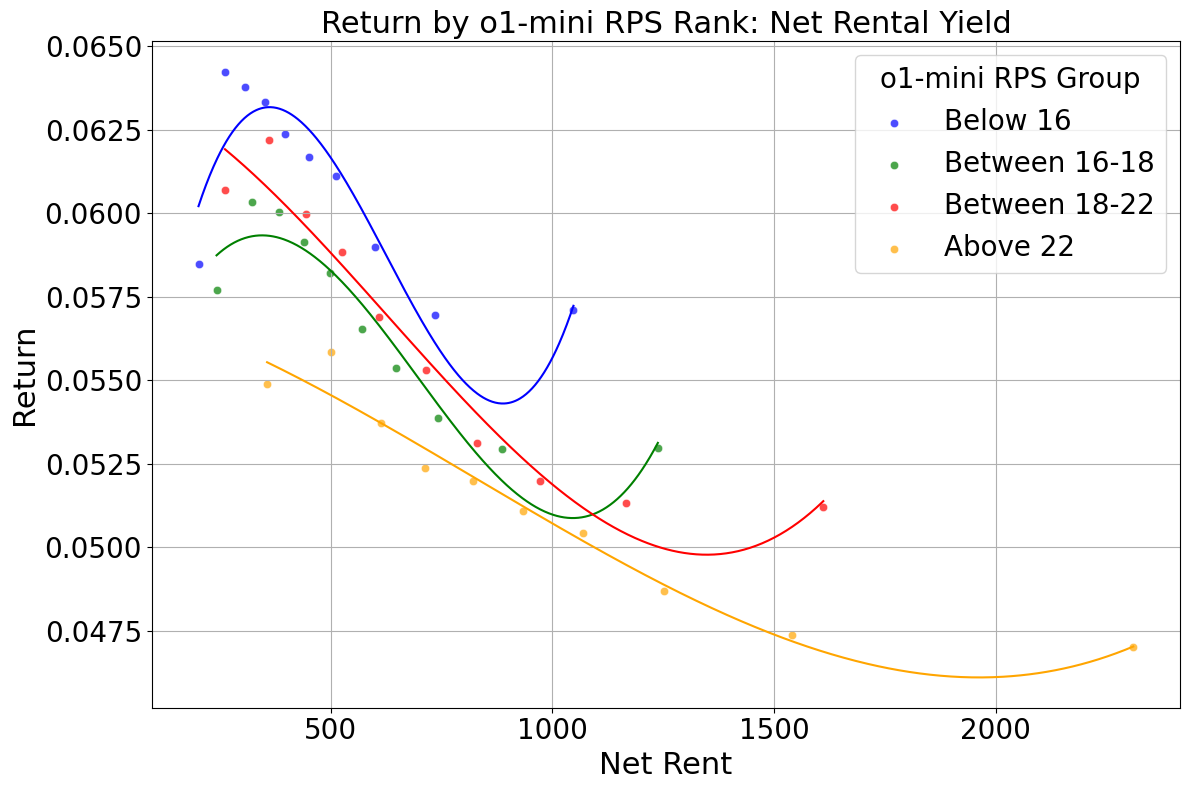

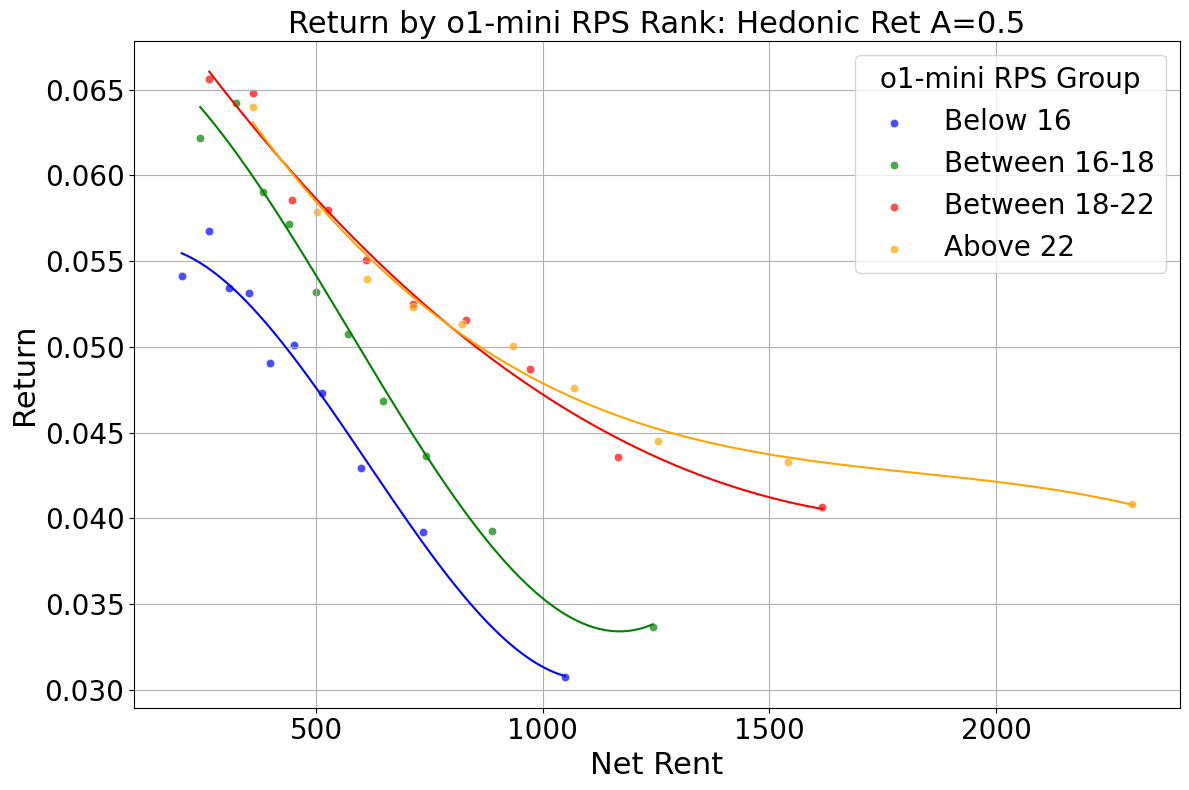

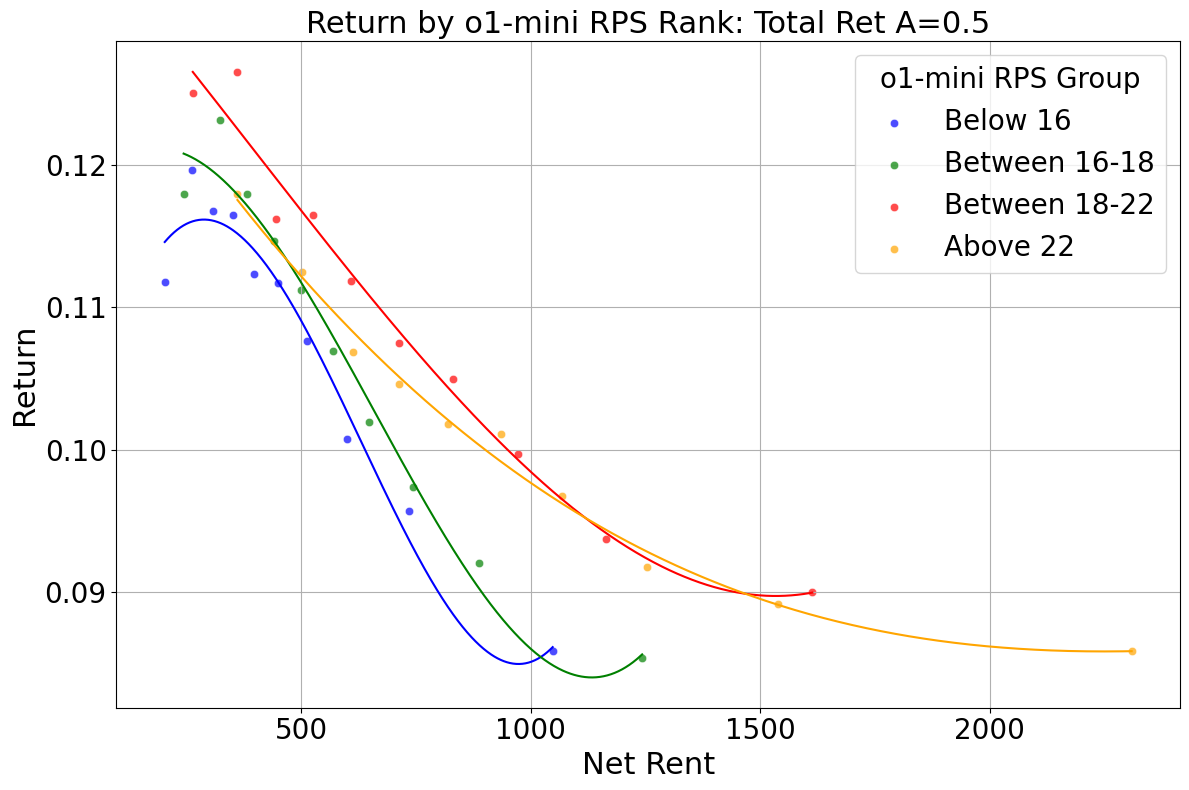

In [11]:
plot_binned_scatter_combined_by_return(ret, return_columns, 'o1-mini RPS Group', title_prefix='Return by o1-mini RPS Rank')

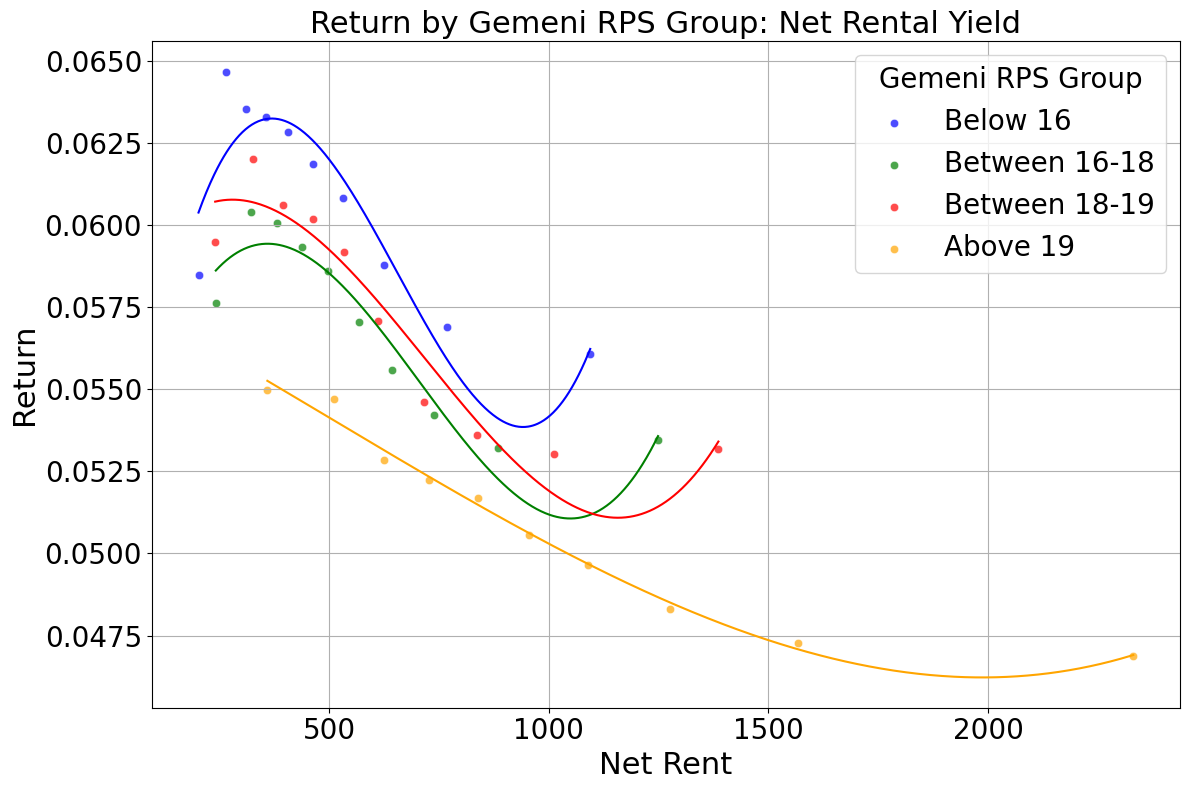

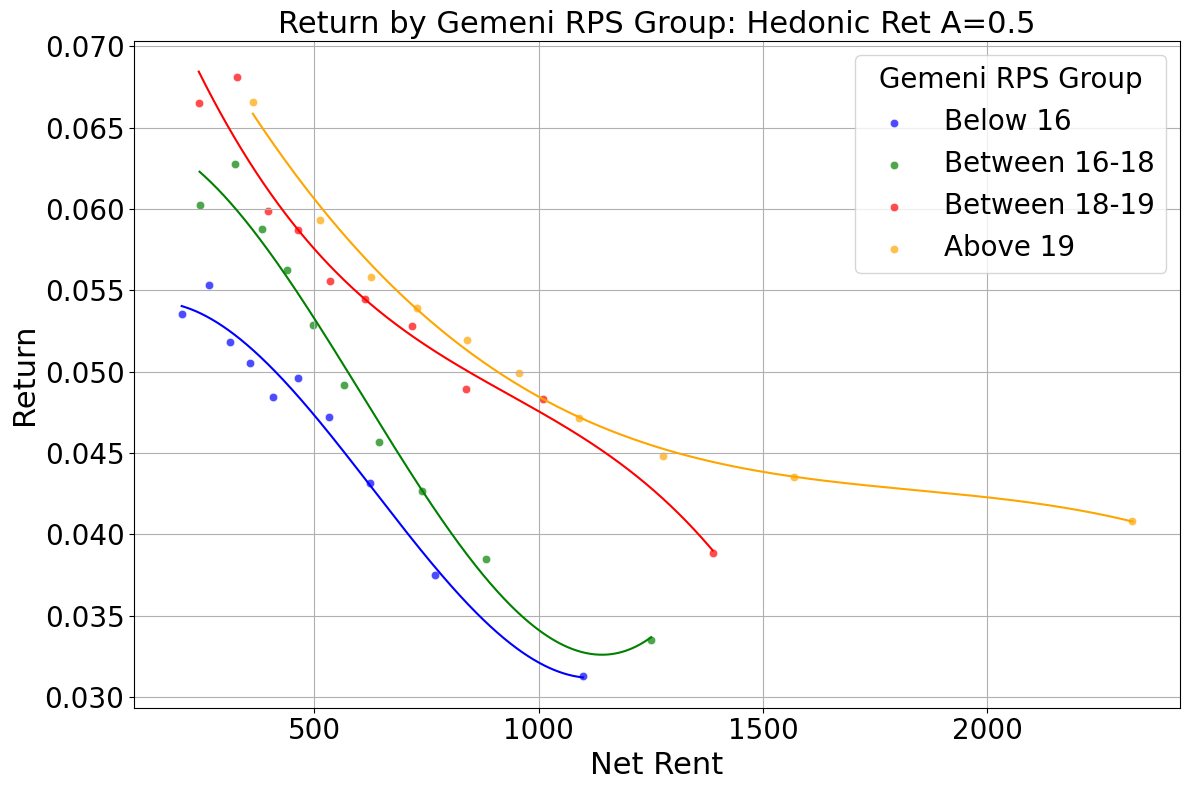

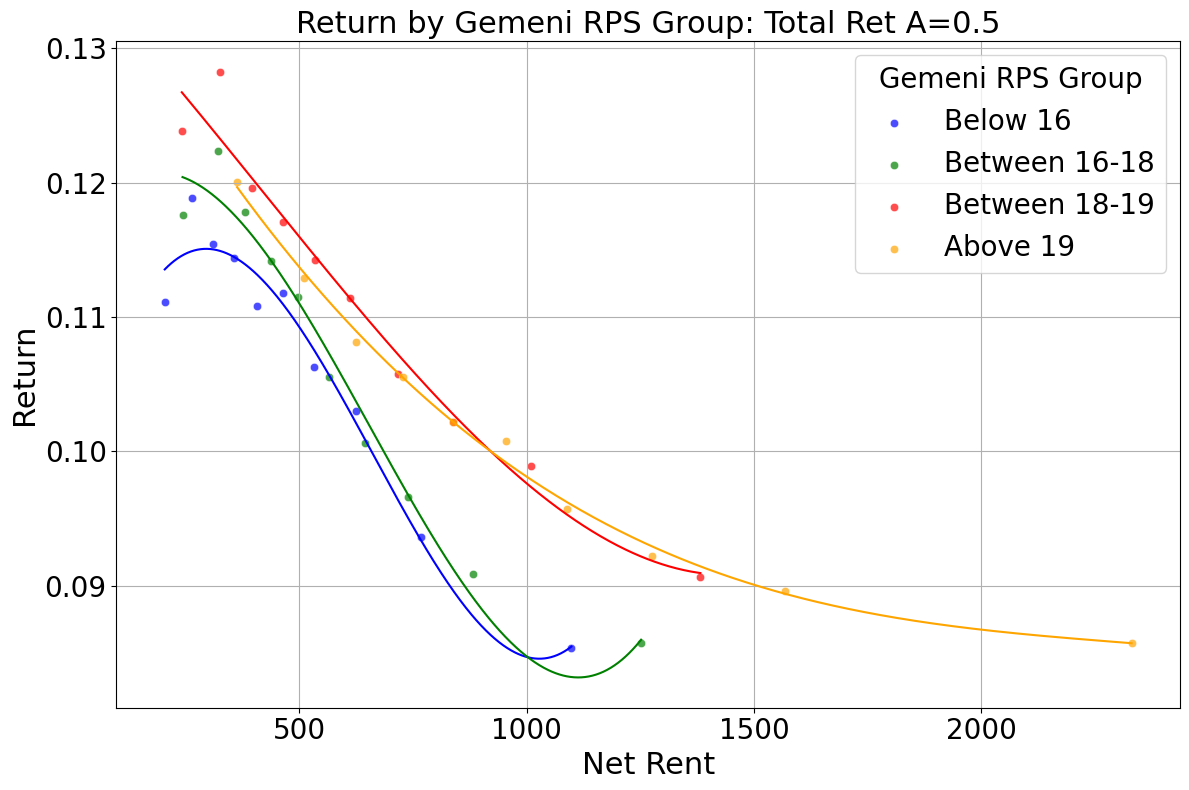

In [12]:
plot_binned_scatter_combined_by_return(ret, return_columns, 'Gemeni RPS Group', title_prefix='Return by Gemeni RPS Group')

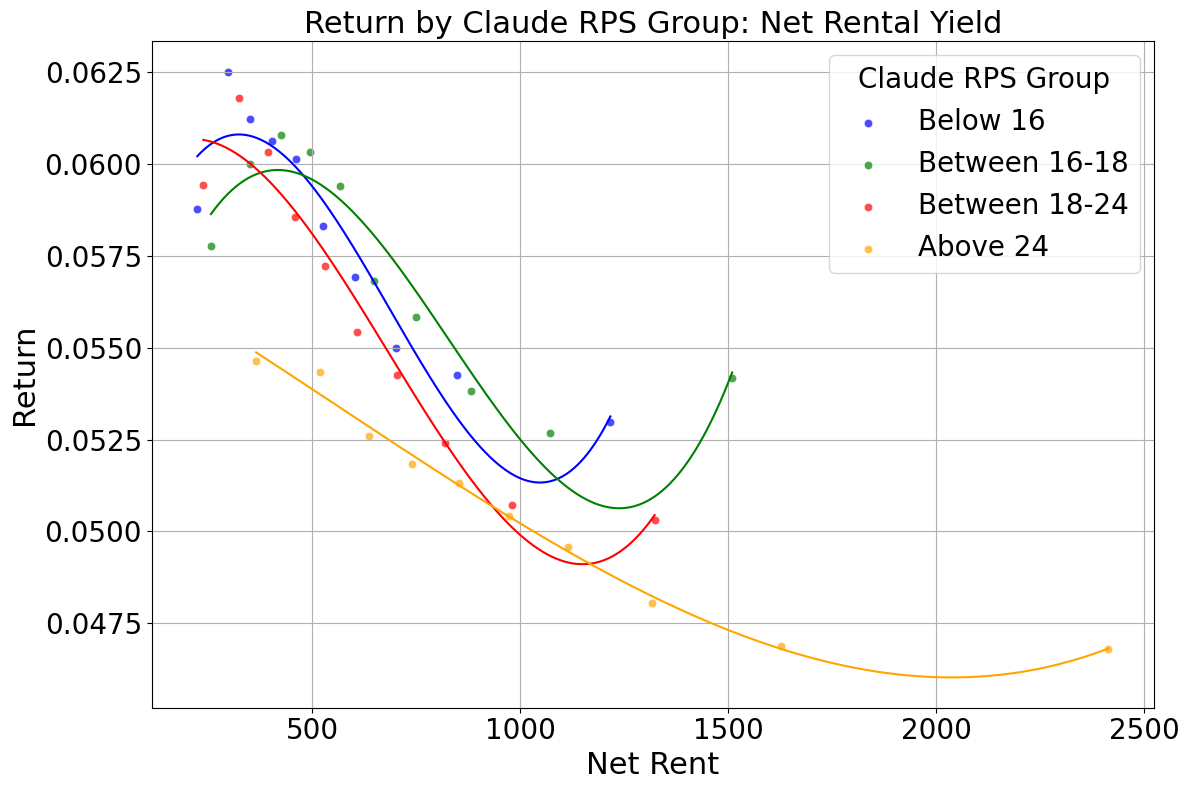

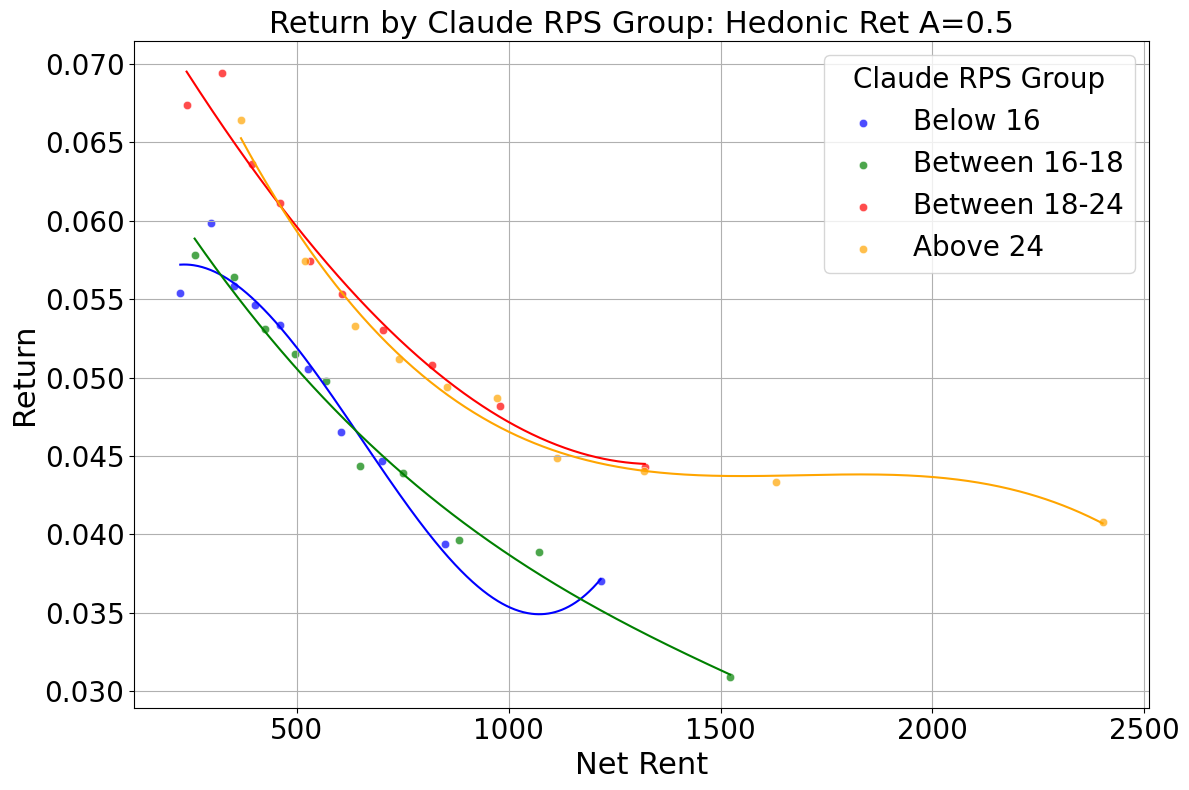

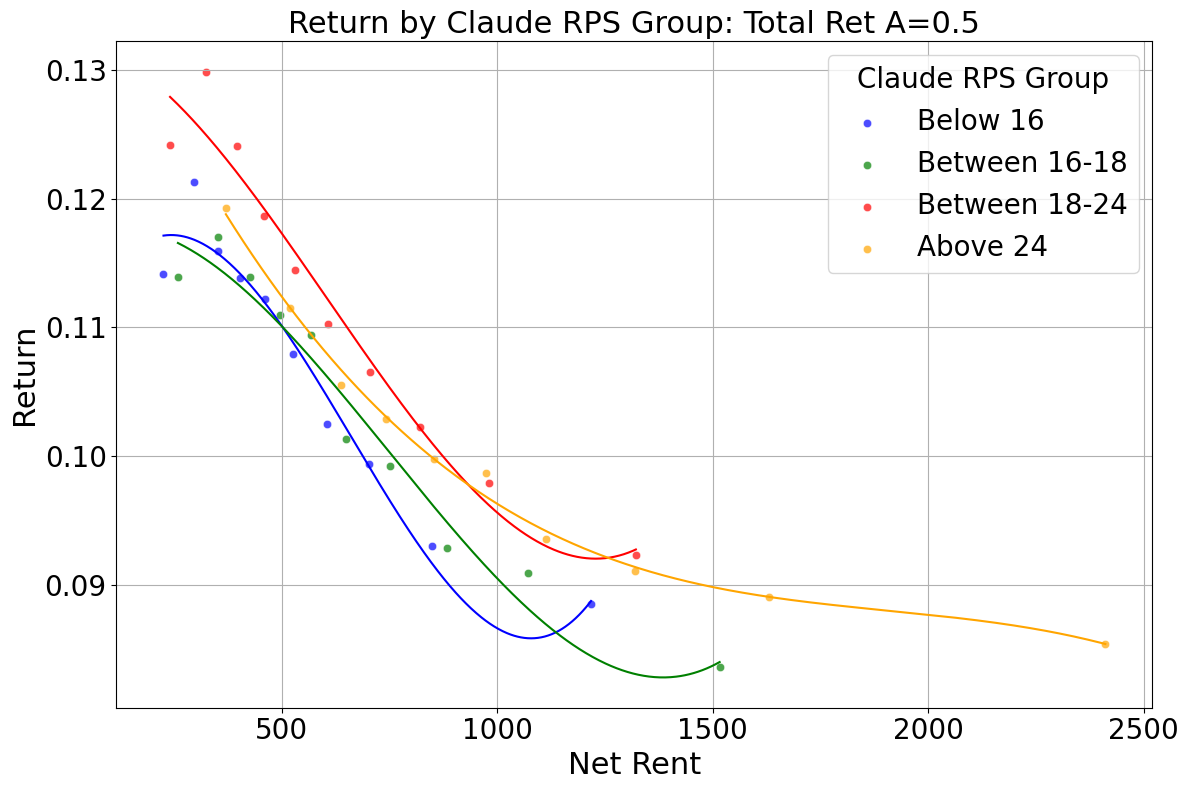

In [13]:
plot_binned_scatter_combined_by_return(ret, return_columns, 'Claude RPS Group', title_prefix='Return by Claude RPS Group')

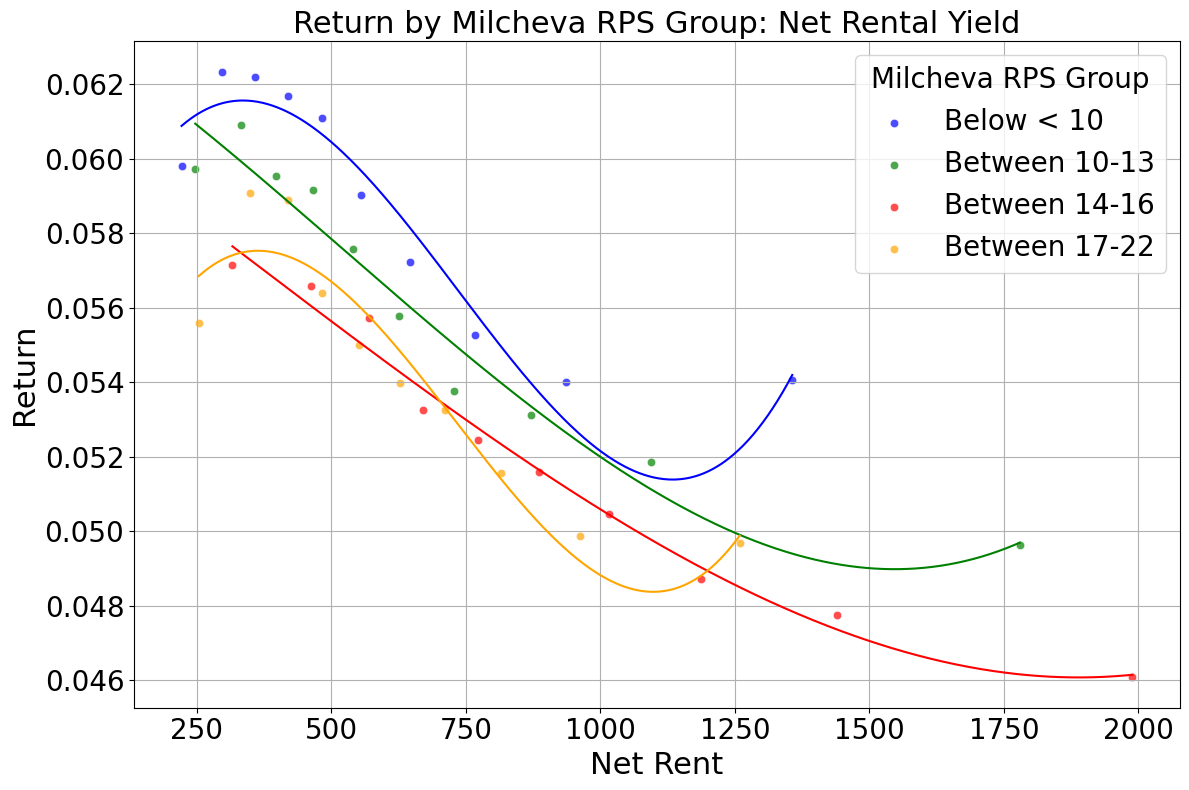

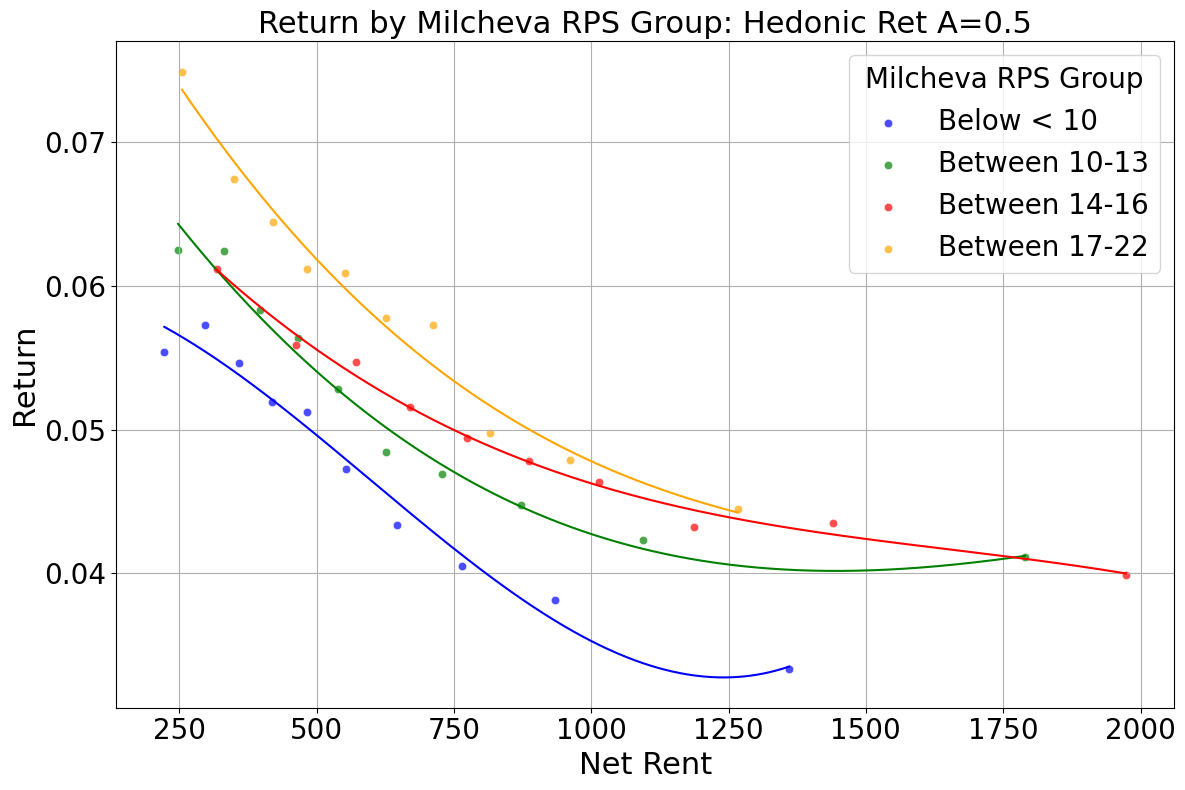

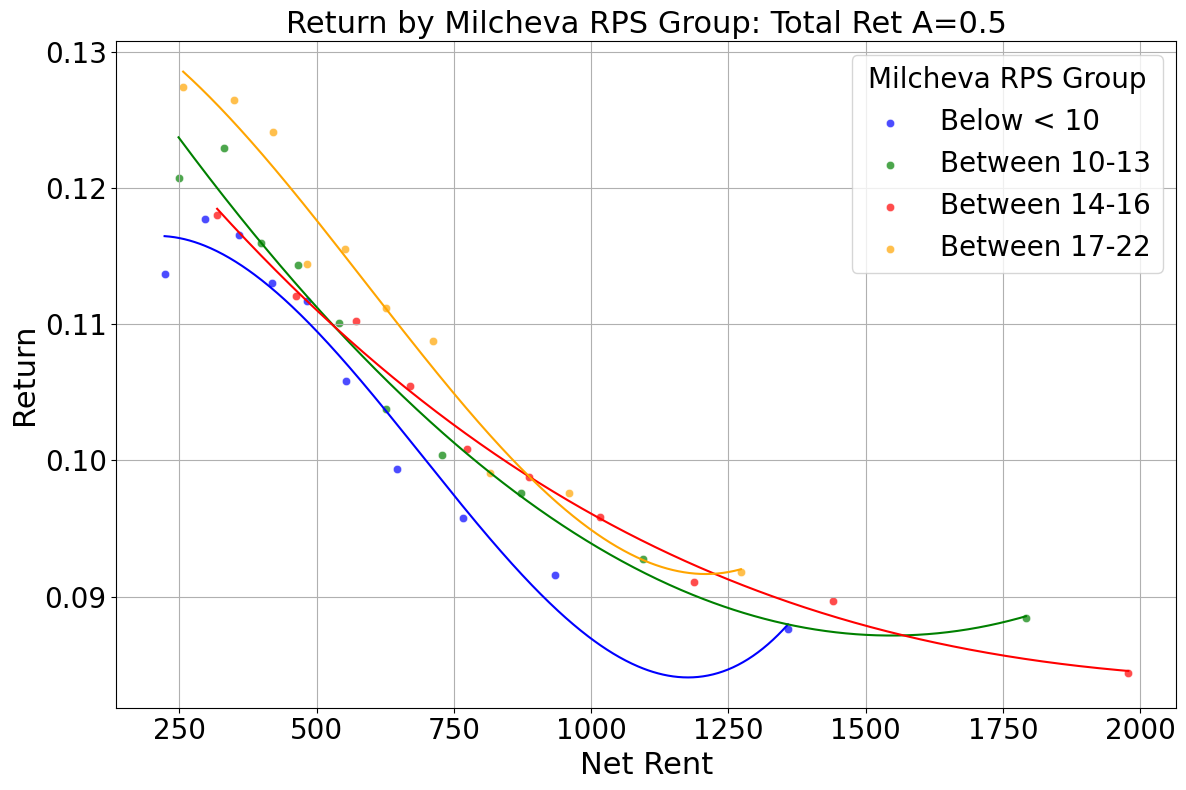

In [14]:
plot_binned_scatter_combined_by_return(ret, return_columns, 'Milcheva RPS Group', title_prefix='Return by Milcheva RPS Group')

In [15]:
epu_index = pd.read_csv('Annualized_EPU_Data.csv')
epu_index_avg = epu_index.groupby('state')[['EPU_State']].mean().reset_index()
# Create 4 quantile bins for EPU_State
epu_index_avg['EPU Group'] = pd.qcut(epu_index_avg['EPU_State'], q=4, labels=['Below 69', 'Between 68-82', 'Between 82-100', 'Above 100'])

# Merge the EPU groups with the `ret` dataframe
ret = ret.merge(epu_index_avg, left_on='Property State', right_on='state', how='left')

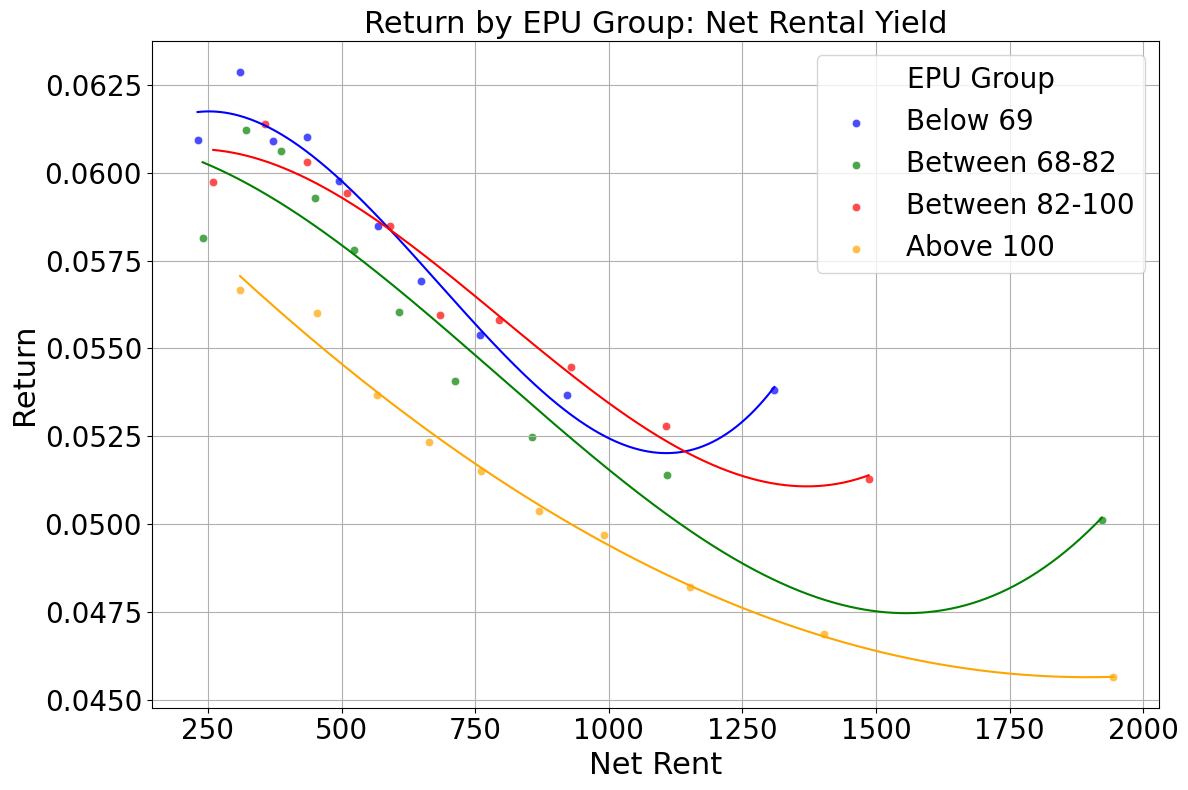

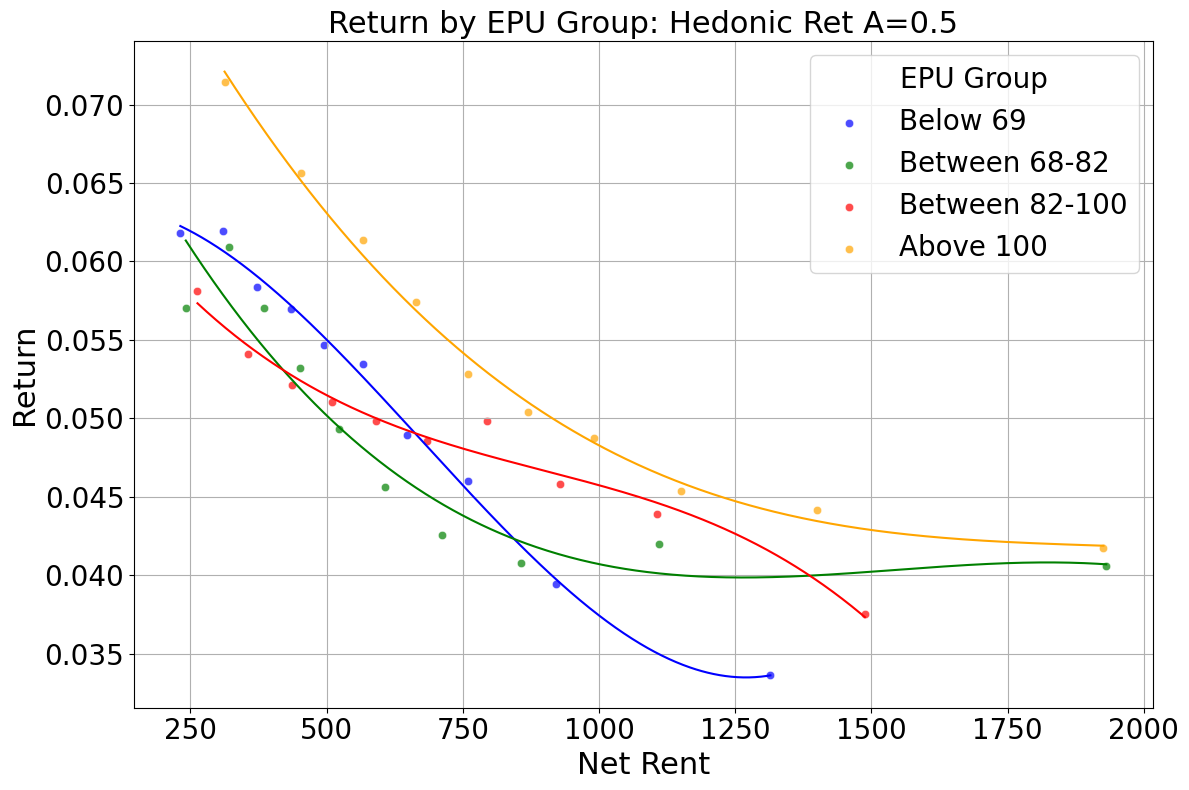

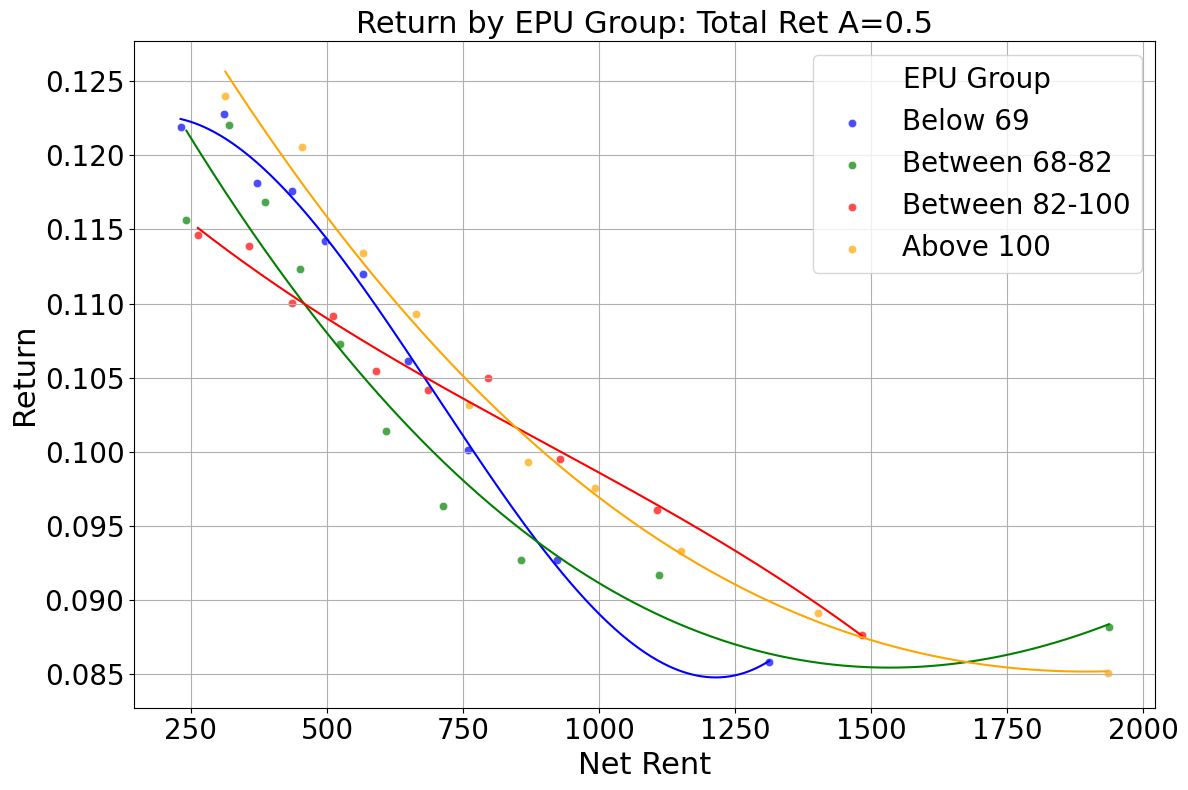

In [16]:
# Plot each return column with all groups in one plot
figsave_name = ['epu_cap_rate', 'epu_cap_gain', 'epu_tot_ret']
plot_binned_scatter_combined_by_return(ret, return_columns, 'EPU Group', title_prefix='Return by EPU Group', figsave_name=figsave_name)

# NOTE: Inforce Figure 18: Cap Rates and Returns By Local Economic Policy Uncertainty   epu_cap_rate.png epu_cap_gain.png epu_tot_ret.png

In [17]:
merged_scores = merged_scores.merge(epu_index_avg, left_on='State', right_on='state', how='left')

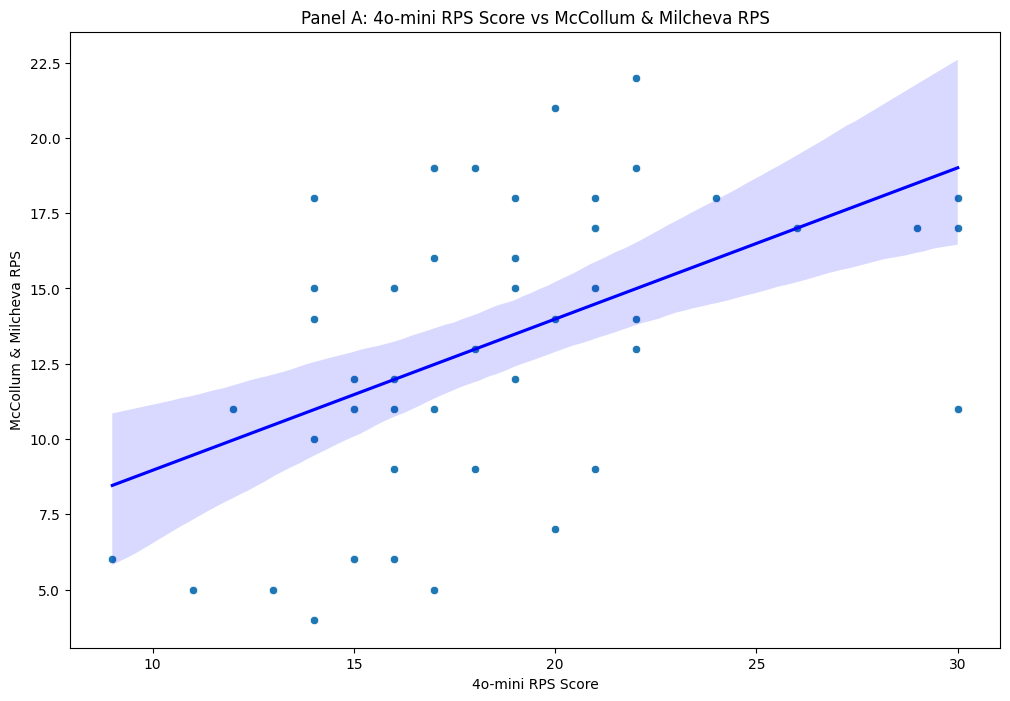

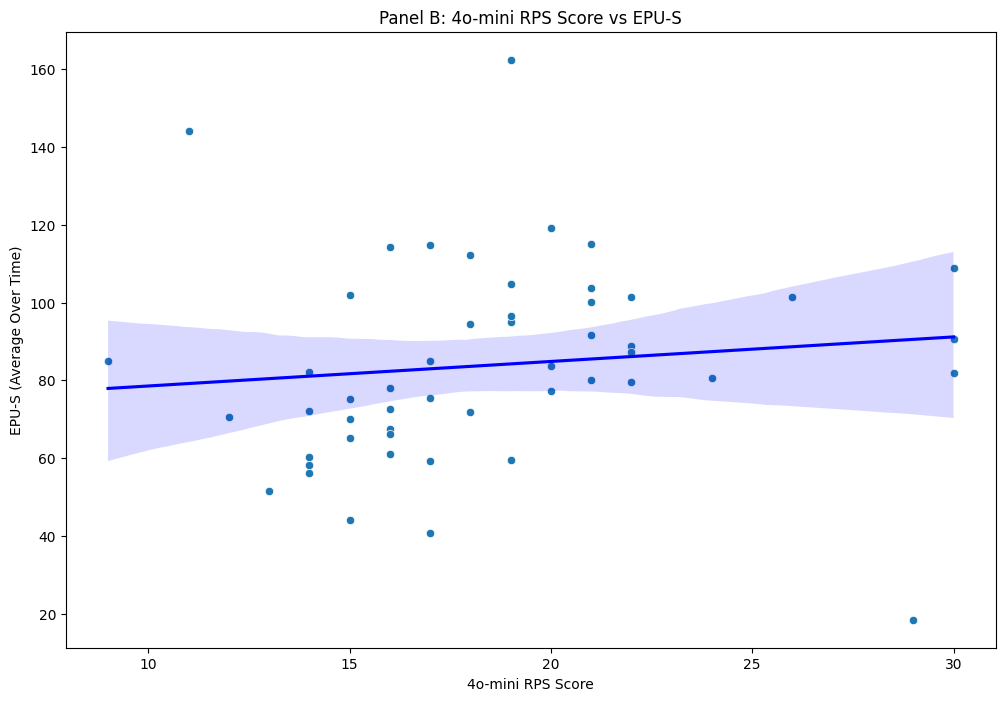

In [18]:
# Panel A: GPT RPS score (x-axis) against McCollum & Milcheva RPS score (y-axis)
plt.figure(figsize=(12, 8))

sns.scatterplot(data=merged_scores, x='4o-mini RPS Score', y='Milcheva RPS')
sns.regplot(data=merged_scores, x='4o-mini RPS Score', y='Milcheva RPS', scatter=False, color='blue')
plt.title('Panel A: 4o-mini RPS Score vs McCollum & Milcheva RPS')
plt.xlabel('4o-mini RPS Score')
plt.ylabel('McCollum & Milcheva RPS')
plt.show()

# Panel B: 4o-mini RPS Score score (x-axis) against EPU-S score (average over time) (y-axis)
plt.figure(figsize=(12, 8))
sns.scatterplot(data=merged_scores, x='4o-mini RPS Score', y='EPU_State')
sns.regplot(data=merged_scores, x='4o-mini RPS Score', y='EPU_State', scatter=False, color='blue')
plt.title('Panel B: 4o-mini RPS Score vs EPU-S')
plt.xlabel('4o-mini RPS Score')
plt.ylabel('EPU-S (Average Over Time)')
plt.show()

## Futuer Renter Protection Risk

In [19]:
state_political_control = pd.read_pickle('state_government.pkl')
state_political_control = state_political_control.rename(columns={'State':'Property State', 'Year':'Year+0'})
ret = ret.merge(state_political_control, on=['Property State', 'Year+0'], how='left')

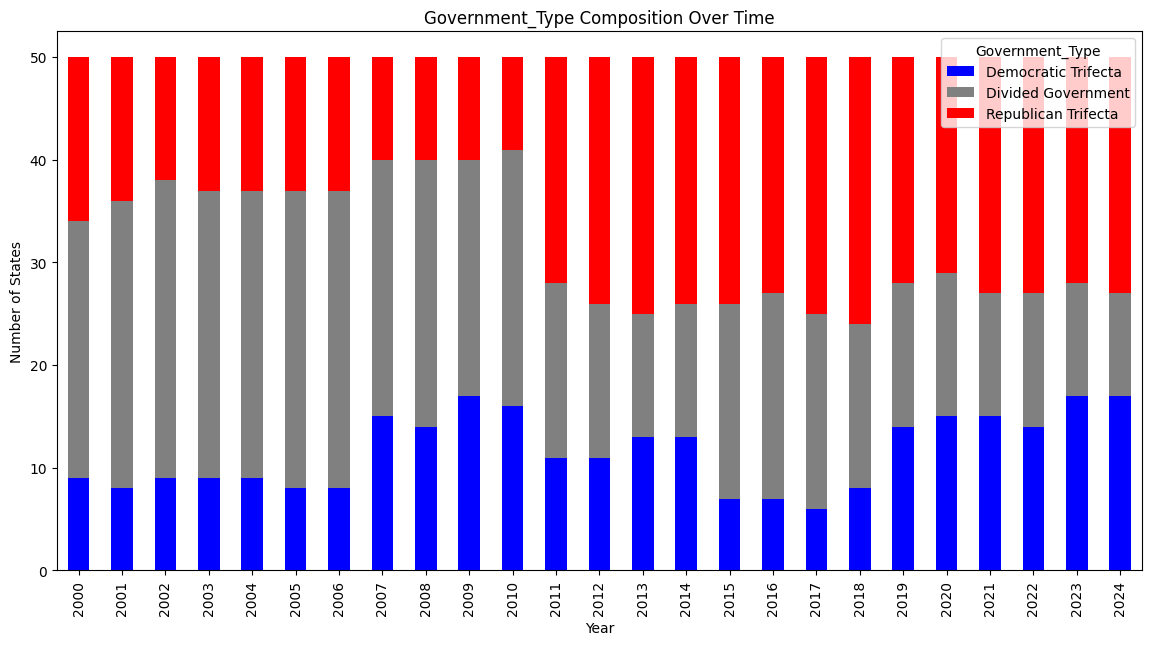

In [20]:
state_political_control = state_political_control[state_political_control['Year+0']!=2025]
def plot_government_composition(df, government_type):
    # Create a pivot table to count the occurrences of each government type per Year+0
    pivot_table = df.pivot_table(index='Year+0', columns=government_type, aggfunc='size', fill_value=0)

    if government_type == 'Government_Type':
        # Define colors for the parties
        colors = {
            'Democratic Trifecta': 'blue',
            'Republican Trifecta': 'red',
            'Divided Government': 'gray'
        }
    elif government_type == 'Senate' or 'House':
        colors = {
            'R' : 'red',
            'D' : 'blue',
            'S' : 'gray'
        }
    elif government_type == 'Governor':
        colors = {
            'R' : 'red',
            'D' : 'blue',
            'I' : 'gray'
        }

    # Plot the bar graph
    pivot_table.plot(kind='bar', stacked=True, figsize=(14, 7), color=[colors.get(col, 'gray') for col in pivot_table.columns])
    plt.title(f'{government_type} Composition Over Time')
    plt.xlabel('Year')
    plt.ylabel('Number of States')
    plt.legend(title=government_type)
    plt.show()
    
# Define the government type you want to analyze
government_type = 'Government_Type'  # You can change this to 'House', 'Senate', or 'Governor'

# Call the function with the dataframe and government type
plot_government_composition(state_political_control, government_type)

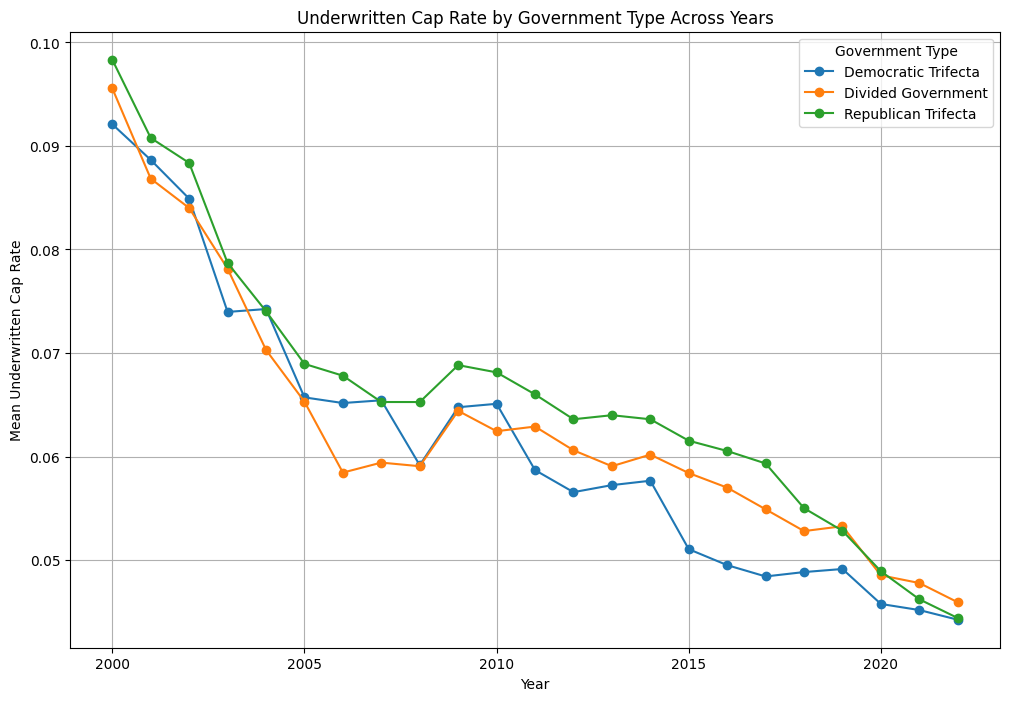

In [21]:
# Group by Government_Type and Year+0, then calculate the mean Underwritten Cap Rate
cap_rate_by_gov_type = ret.groupby(['Government_Type', 'Year+0'])['Underwritten Cap Rate'].median().unstack()

# Plot the cap rate by government type across years
cap_rate_by_gov_type.T.plot(figsize=(12, 8), marker='o')
plt.title('Underwritten Cap Rate by Government Type Across Years')
plt.xlabel('Year')
plt.ylabel('Mean Underwritten Cap Rate')
plt.grid(True)
plt.legend(title='Government Type')
plt.show()

In [22]:
# Function to plot binned scatter plots for each return column with Government Type in one plot
def plot_binned_scatter_by_gov_type(data, return_columns, gov_type_column='Government_Type', num_bins=10, title_prefix='Return by Government Type', figsave_name=None):
    for idx, ret_col in enumerate(return_columns):
        # Initialize a figure
        fig, ax = plt.subplots(figsize=(12, 8))

        # Get unique government types
        gov_types = data[gov_type_column].unique()

        # Define colors for the parties based on government type
        if gov_type_column == 'Government_Type':
            colors = {
                'Democratic Trifecta': 'blue',
                'Republican Trifecta': 'red',
                'Divided Government': 'gray'
            }
        elif gov_type_column in ['Senate', 'House']:
            colors = {
                'R': 'red',
                'D': 'blue',
                'S': 'gray'
            }
        elif gov_type_column == 'Governor':
            colors = {
                'R': 'red',
                'D': 'blue',
                'I': 'gray'
            }

        # Loop through each government type and plot on the same graph
        for gov_type in gov_types:
            gov_data = data[data[gov_type_column] == gov_type]

            # Apply binning based on Real Underwritten Annual NCF Per Unit
            gov_data['NOI_Bin'], bin_edges = pd.qcut(
                gov_data['Real Underwritten Annual NCF Per Unit'], 
                q=num_bins, 
                retbins=True, 
                duplicates='drop'
            )

            # Filter the return column data
            filtered_data = gov_data[(gov_data[ret_col] >= -0.05) & (gov_data[ret_col] <= 0.24)]

            # Calculate the mean NOI and dependent variable for each bin
            binned_data = filtered_data.groupby('NOI_Bin').agg({
                'Real Underwritten Annual NCF Per Unit': 'median',
                ret_col: 'median'
            }).reset_index().rename(columns={'Real Underwritten Annual NCF Per Unit': 'mean_noi'})
            
            # New 250130: Convert annual NOI to monthly NOI
            binned_data['mean_noi'] = binned_data['mean_noi']/12

            # Plot data points for the current government type
            sns.scatterplot(
                data=binned_data,
                x='mean_noi',
                y=ret_col,
                ax=ax,
                color=colors.get(gov_type, 'black'),  # Default to black if gov_type not in colors
                alpha=0.7,
                label=f'{gov_type}'
            )

            # Fit a spline through the binned data points
            if not binned_data.empty:
                spline = UnivariateSpline(binned_data['mean_noi'], binned_data[ret_col], s=1)
                x_spline = np.linspace(min(binned_data['mean_noi']), max(binned_data['mean_noi']), 500)
                y_spline = spline(x_spline)
                ax.plot(x_spline, y_spline, color=colors.get(gov_type, 'black'))

        # Set plot details
        # New formats 250130
        ax.set_xlabel('Net Rent', fontsize=22)
        ax.set_ylabel('Return', fontsize=22)
        ax.tick_params(axis='both', labelsize=20)  # Increase font size for both x and y ticks
        if ret_col == 'Underwritten Cap Rate':   # rename
            ret_col = 'Net Rental Yield'

        # ax.set_xlim(0, 30000)
        # ax.set_xlabel('Real Underwritten Annual NCF Per Unit', fontsize=14)
        # ax.set_ylabel('Return', fontsize=14)


        plt.title(f'{title_prefix}: {ret_col}', fontsize=22)   # used to be 16
        plt.grid(True)
        plt.legend(title=gov_type_column, fontsize=20, title_fontsize=20)
        plt.tight_layout()

        if figsave_name:   # New 
            plt.savefig(f'Figures/{figsave_name[idx]}.png')

        plt.show()


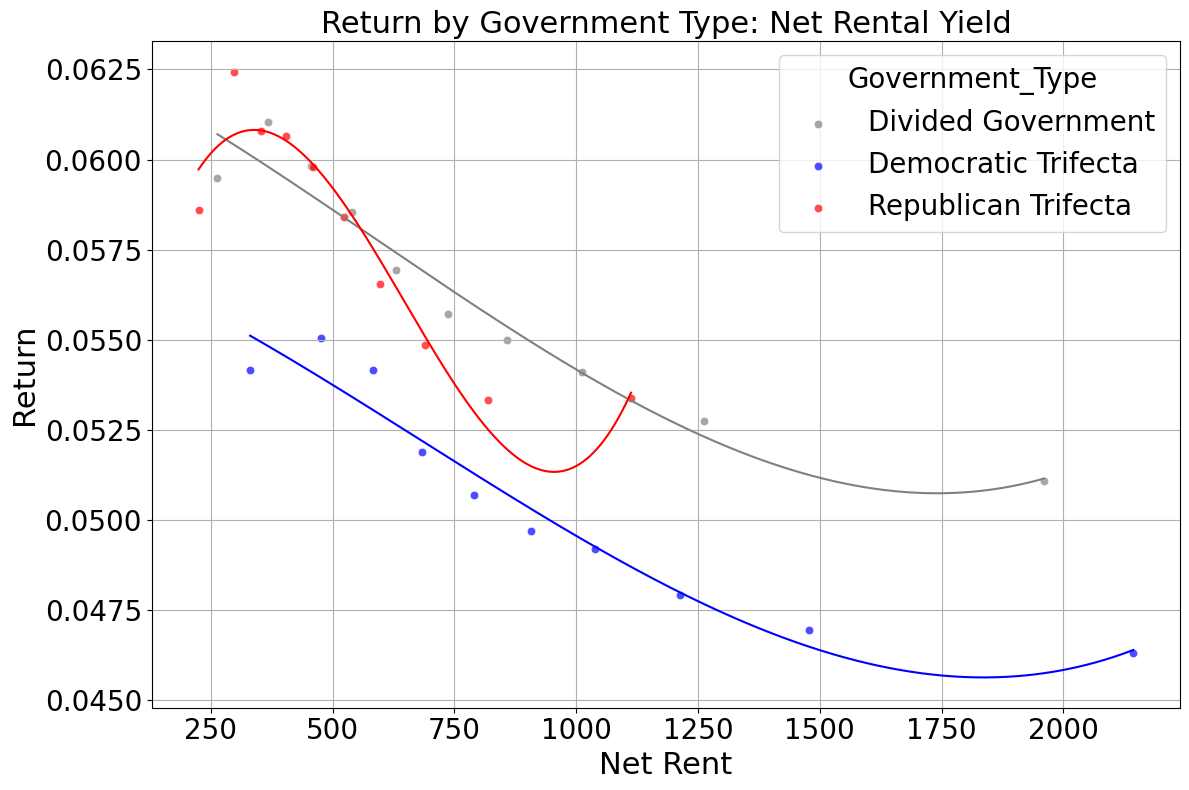

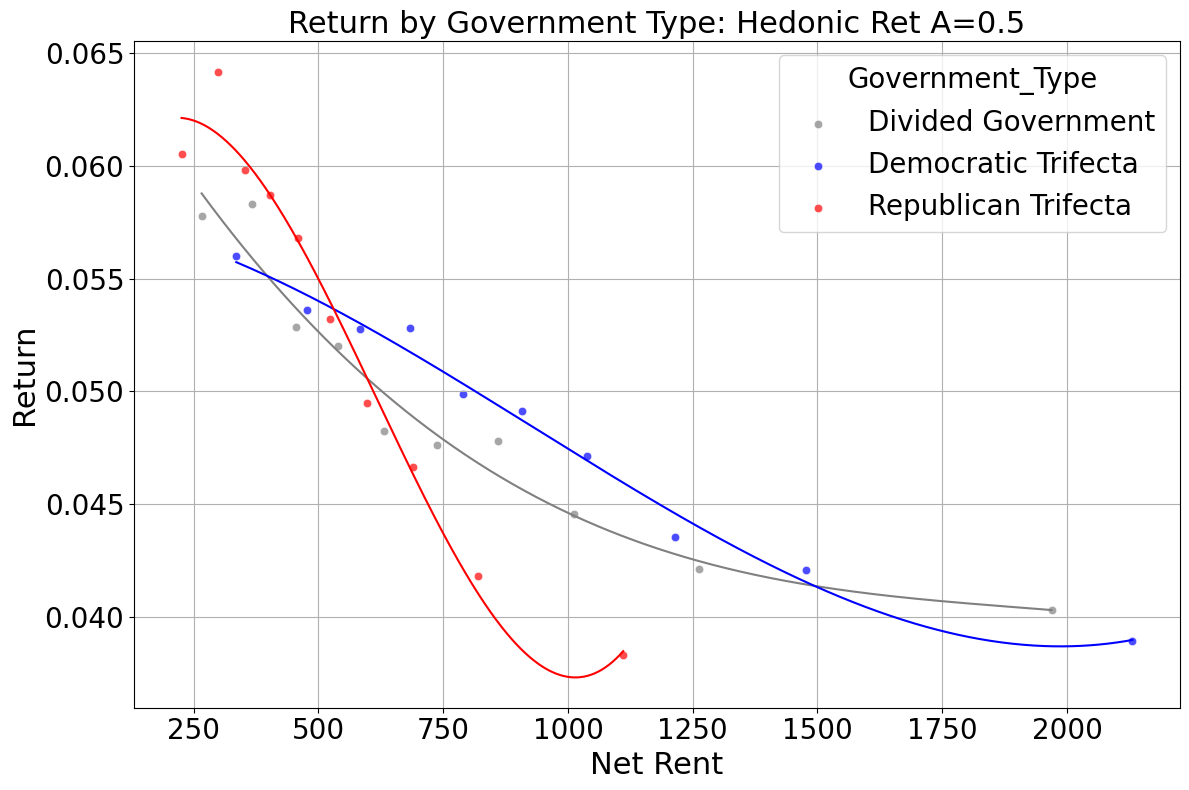

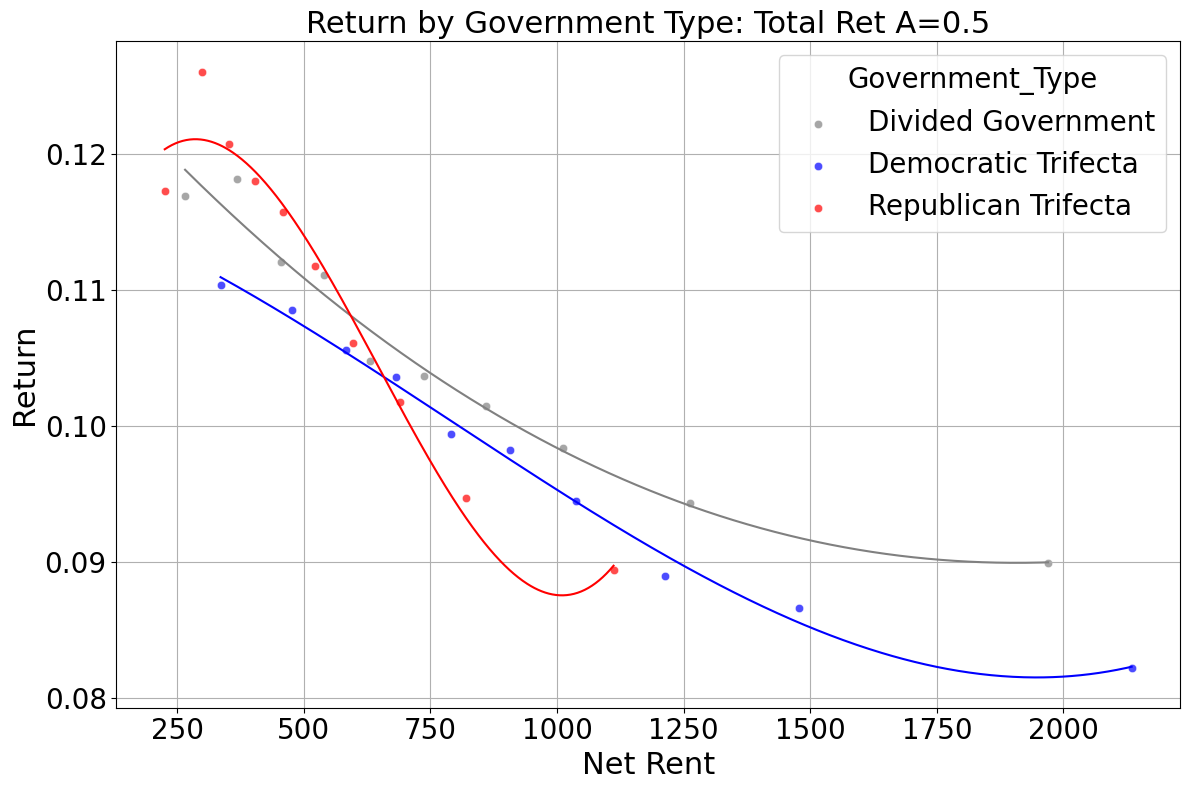

In [23]:
# Example call to the function
figsave_name = ['trifecta_cap_rate', 'trifecta_cap_gain', 'trifecta_tot_ret']
plot_binned_scatter_by_gov_type(ret, return_columns, gov_type_column='Government_Type', title_prefix='Return by Government Type', figsave_name=figsave_name)

# NOTE: INFORCE Figure 19: Cap Rates and Returns by Political Control Groups  trifecta_cap_rate.png  trifecta_tot_ret.png